<a href="https://colab.research.google.com/github/Nitishgautam21/Zeoptap-Assignment/blob/main/Nitish_Gautam_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Loading, Merging and Preprocessing Datasets

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

df = pd.merge(transactions, customers, on='CustomerID', how='inner')
df = pd.merge(df, products, on="ProductID", how="inner")

df.head(3)


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [3]:
df = df.drop(columns=['Price_y'])
df = df.rename(columns={'Price_x': 'Price'})

# Convert 'TransactionDate' to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Convert 'SignupDate' to datetime
df['SignupDate'] = pd.to_datetime(df['SignupDate'])

In [4]:
df.head(3)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics


# Insight 1: Customer Segmentation

**RFM Analysis – We'll compute the Recency, Frequency, and Monetary (RFM) metrics for customer segmentation.**

In [5]:
# Step 1: Feature Engineering

# Calculate Recency (days since last purchase)
recency = df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (df['TransactionDate'].max() - recency['TransactionDate']).dt.days

# Calculate Frequency (number of transactions)
frequency = df.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency = frequency.rename(columns={'TransactionID': 'Frequency'})

# Calculate Monetary (total spend)
monetary = df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary = monetary.rename(columns={'TotalValue': 'Monetary'})

# Merge all the features into one DataFrame
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

In [6]:
# Step 2: Standardizing the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


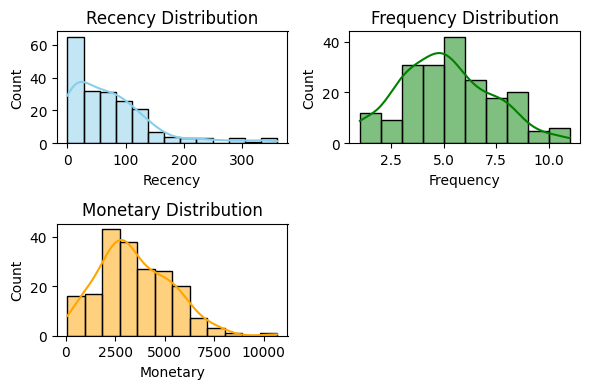

In [7]:
# Step 3: Visualize the Segments

# 1. RFM Distribution
plt.figure(figsize=(6, 4))

# Recency Distribution
plt.subplot(2, 2, 1)
sns.histplot(rfm['Recency'], kde=True, color='skyblue')
plt.title('Recency Distribution')

# Frequency Distribution
plt.subplot(2, 2, 2)
sns.histplot(rfm['Frequency'], kde=True, color='green')
plt.title('Frequency Distribution')

# Monetary Distribution
plt.subplot(2, 2, 3)
sns.histplot(rfm['Monetary'], kde=True, color='orange')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()


In [8]:
# Find the best k with minimum DBI
dbi_scores = []

# Test different values of k (from 2 to 10)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

    # Calculate DBI for the current k
    dbi = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
    dbi_scores.append(dbi)

# Find the best k with the minimum DBI
best_k = range(2, 11)[dbi_scores.index(min(dbi_scores))]
min_dbi = min(dbi_scores)

print(f"Optimal number of clusters (k): {best_k}")
print(f"Minimum Davies-Bouldin Index (DBI): {min_dbi}")

# Step 1: Perform KMeans clustering with the best k (instead of using k=4)
kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 3: Check how many data points are in each cluster
cluster_counts = rfm['Cluster'].value_counts()
print(f"Cluster counts:\n{cluster_counts}")

# Step 4: Create the 3D plot using Plotly
fig = px.scatter_3d(rfm,
                    x='Recency',
                    y='Frequency',
                    z='Monetary',
                    color='Cluster',
                    hover_data=['CustomerID'],
                    title=f"3D Customer Segmentation (DBI: {min_dbi:.2f}, k={best_k})",
                    labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'Monetary': 'Monetary'})

# Show the plot
fig.show()


Optimal number of clusters (k): 3
Minimum Davies-Bouldin Index (DBI): 0.880153375840541
Cluster counts:
Cluster
1    110
0     71
2     18
Name: count, dtype: int64


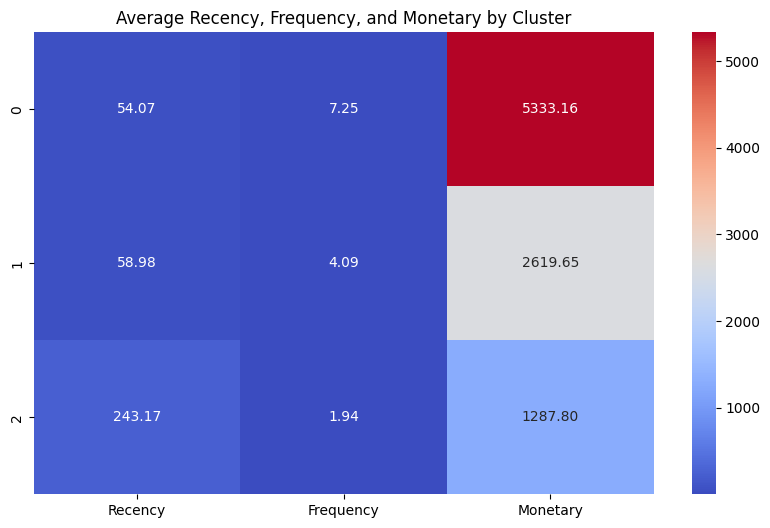

In [9]:
# 3. Cluster Profile Plot
cluster_profile = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profile[['Recency', 'Frequency', 'Monetary']], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Average Recency, Frequency, and Monetary by Cluster')
plt.show()


# Insight 2: Regional Preferences

**Transaction Distribution by Region**

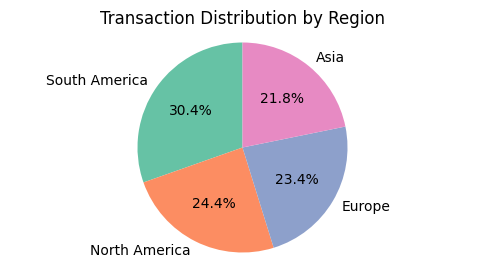

In [10]:
# Group by Region for analyzing the distribution and total sales
region_sales = df.groupby('Region')['TotalValue'].sum()
region_transactions = df.groupby('Region')['TransactionID'].count()

# Plot 1: Pie Chart for Region Distribution (Proportion of Transactions)
region_distribution = df['Region'].value_counts()

plt.figure(figsize=(6, 3))
plt.pie(region_distribution, labels=region_distribution.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Transaction Distribution by Region')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.show()


**Sales distribution by Region**

In [9]:
plt.figure(figsize=(6, 4))
plt.pie(region_sales.values, labels=region_sales.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette('viridis', len(region_sales)))

plt.title('Total Sales by Region', fontsize=18, fontweight='bold', fontname='Arial')

plt.show()



**Heatmap of total sales by region**

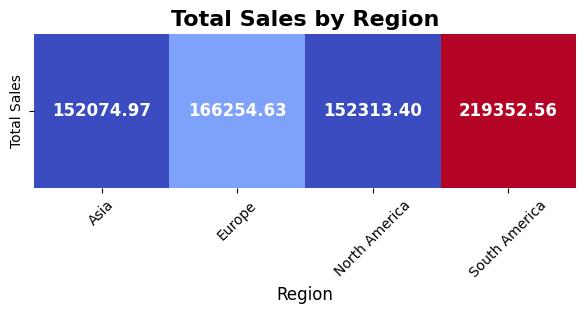

In [11]:
plt.figure(figsize=(7, 2))
sns.heatmap(region_sales.values.reshape(1, -1), annot=True, fmt='.2f', cmap='coolwarm', cbar=False,
            xticklabels=region_sales.index, yticklabels=['Total Sales'], annot_kws={'size': 12, 'weight': 'bold'})
plt.title('Total Sales by Region', fontsize=16, fontweight='bold', fontname='Arial')
plt.ylabel('')
plt.xlabel('Region', fontsize=12)
plt.xticks(rotation=45)
plt.show()


**Heatmap of Total Sales by Region and Category**

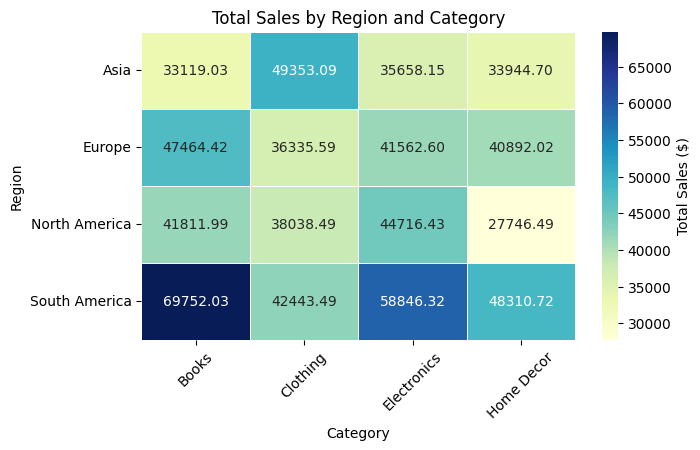

In [12]:
# Group by Region and Category to sum up TotalValue
region_category_sales = df.groupby(['Region', 'Category'])['TotalValue'].sum().unstack()

# Plot: Heatmap for Total Sales by Region and Category
plt.figure(figsize=(7, 4))
sns.heatmap(region_category_sales, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Total Sales ($)'})
plt.title('Total Sales by Region and Category')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

**BarPlot of Sales by Region and Category**

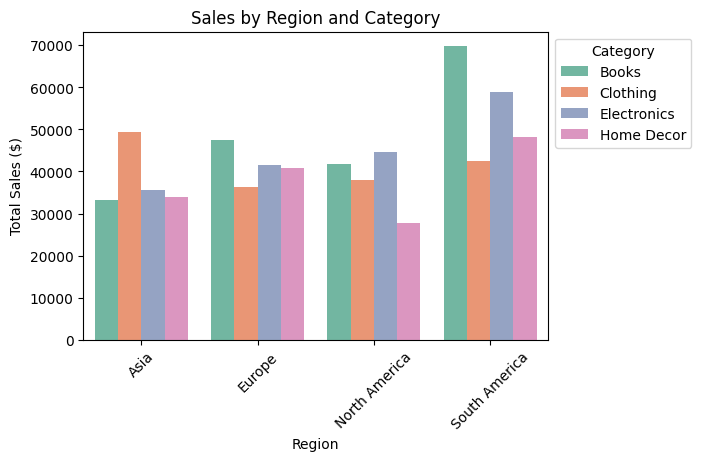

In [14]:
# bar plot to show sales for each region by category
region_category_sales = region_category_sales.reset_index()
region_category_sales_melted = region_category_sales.melt(id_vars='Region', value_vars=region_category_sales.columns[1:], var_name='Category', value_name='TotalSales')

plt.figure(figsize=(6, 4))
sns.barplot(x='Region', y='TotalSales', hue='Category', data=region_category_sales_melted, palette='Set2')
plt.title('Sales by Region and Category')
plt.xlabel('Region')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**Barplot of top 3 products by region**

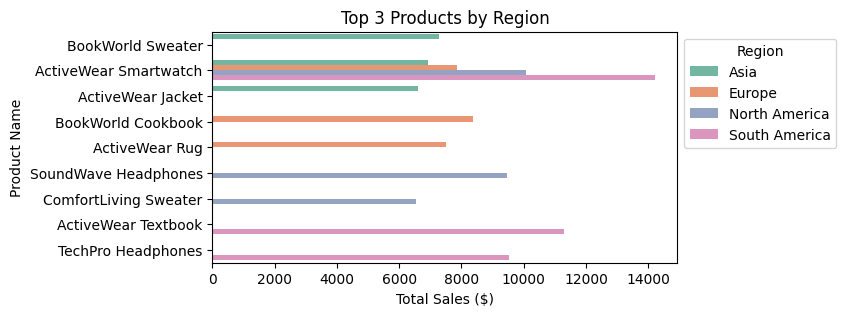

In [16]:
# Group by Region and ProductName, summing TotalValue for each combination
region_product_sales = df.groupby(['Region', 'ProductName'])['TotalValue'].sum().reset_index()

# Sort the data by TotalValue in descending order within each region
region_product_sales_sorted = region_product_sales.sort_values(by=['Region', 'TotalValue'], ascending=[True, False])

# Function to get top 5 products for each region
top_3_products_per_region = region_product_sales_sorted.groupby('Region').head(3)

plt.figure(figsize=(6, 3))
sns.barplot(x='TotalValue', y='ProductName', hue='Region', data=top_3_products_per_region, palette='Set2')
plt.title('Top 3 Products by Region')
plt.xlabel('Total Sales ($)')
plt.ylabel('Product Name')
plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Insight 3: Transaction patterns

**Monthly sales over time**

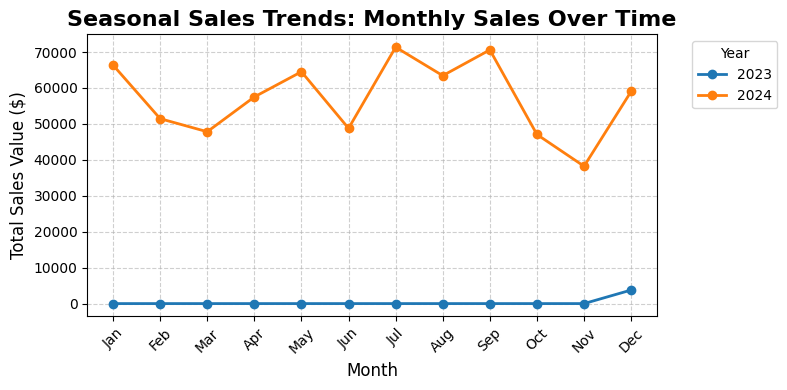

In [25]:
# Step 1: Extract 'Year' and 'Month' from 'TransactionDate'
df['Year'] = df['TransactionDate'].dt.year
df['Month'] = df['TransactionDate'].dt.month

# Step 2: Group by 'Year' and 'Month', and sum the 'TotalValue'
monthly_sales = df.groupby(['Year', 'Month'])['TotalValue'].sum().reset_index()

# Step 3: Create a Pivot Table with 'Month' as index, 'Year' as columns, and 'TotalValue' as values
monthly_sales_pivot = monthly_sales.pivot(index='Month', columns='Year', values='TotalValue').fillna(0)

# Step 4: Plotting the data
plt.figure(figsize=(8, 4))

# Plotting each year with a line and markers
for year in monthly_sales_pivot.columns:
    plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[year], marker='o', label=str(year), linewidth=2)

# Adding title and labels
plt.title('Seasonal Sales Trends: Monthly Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales Value ($)', fontsize=12)

# Customizing x-ticks for months
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Adding gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adding a legend to distinguish the years
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Tight layout for proper spacing
plt.tight_layout()

# Show the plot
plt.show()


**Monthly Number of Transactions from Start to End Date**

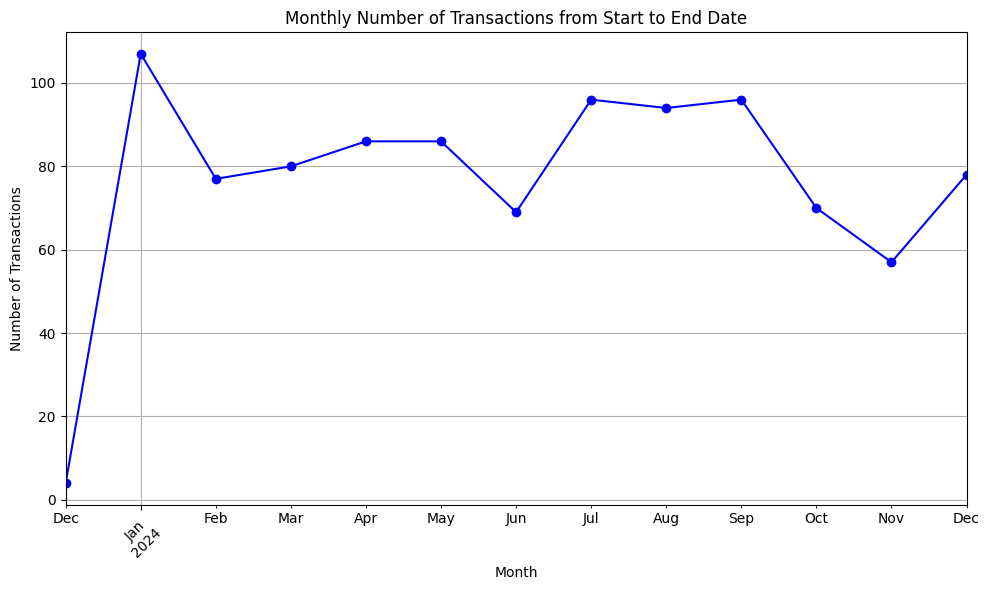

In [27]:
# Create a 'Year-Month' column to group by both year and month
df['YearMonth'] = df['TransactionDate'].dt.to_period('M')

# Count the number of transactions per month
monthly_transactions = df.groupby('YearMonth').size()

# Plot the data as a line graph
plt.figure(figsize=(6, 3))
monthly_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Monthly Number of Transactions from Start to End Date')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

**Number of Signups per Year**

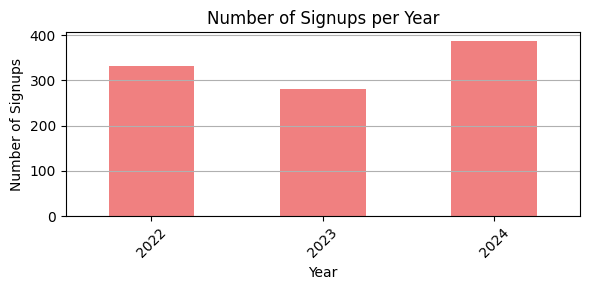

In [29]:
# Extract the year from 'SignupDate'
df['SignupYear'] = df['SignupDate'].dt.year

# Group by year and count the number of signups
signups_per_year = df.groupby('SignupYear').size()

# Plot the data as a bar chart
plt.figure(figsize=(6, 3))
signups_per_year.plot(kind='bar', color='lightcoral')
plt.title('Number of Signups per Year')
plt.xlabel('Year')
plt.ylabel('Number of Signups')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()

# Show the plot
plt.show()


**Number of Transactions per Month in 2024**

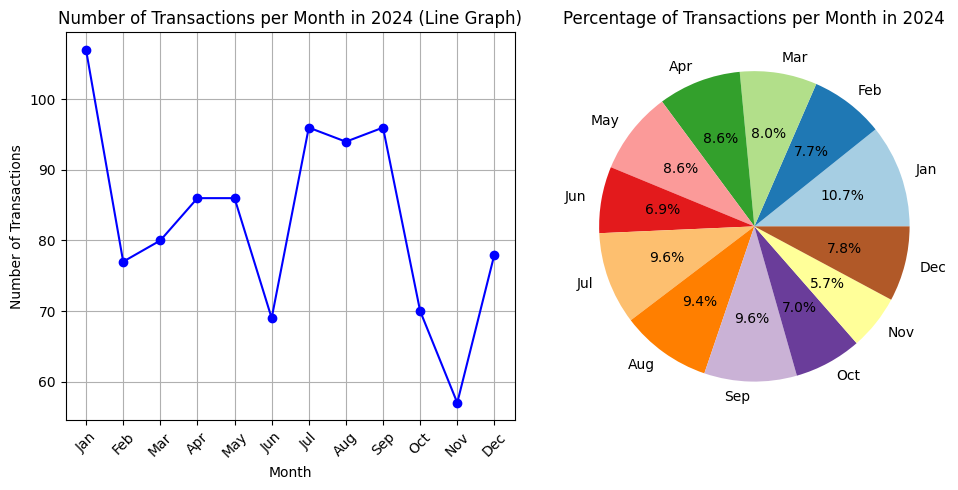

In [34]:
# Filter the data for the year 2024
df_2024 = df[df['TransactionDate'].dt.year == 2024]

# Group by month and count the number of transactions
transactions_per_month_2024 = df_2024.groupby('Month').size()

# Month names for labeling in the pie chart and line plot
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Line Graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

# Plotting the line graph with correct x-axis labels (month names)
plt.plot(month_names, transactions_per_month_2024.values, marker='o', color='b')
plt.title('Number of Transactions per Month in 2024 (Line Graph)')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(True)

# Pie Chart
plt.subplot(1, 2, 2)
plt.pie(transactions_per_month_2024, labels=month_names, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Percentage of Transactions per Month in 2024')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


# Insight 4: Product Popularity and Sales Trends

**Bar Chart for Top Products by Total Sales**

<ipython-input-20-a4cc3b8ac5bc>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




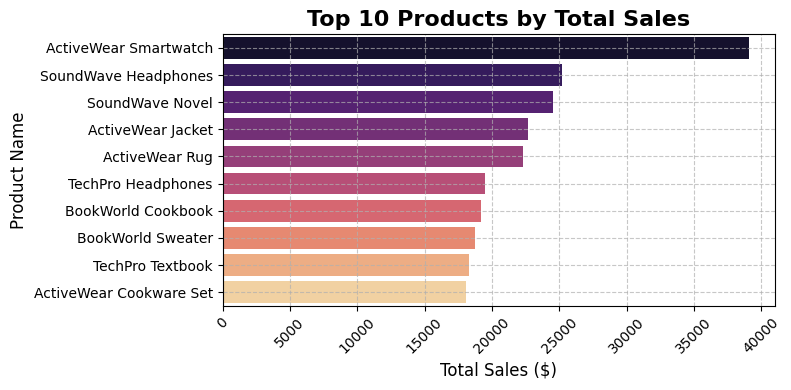

In [20]:
# Group by Product and sum the TotalValue or Quantity
product_sales = df.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x=product_sales.values, y=product_sales.index, palette='magma')
plt.title('Top 10 Products by Total Sales', fontsize=16, fontweight='bold')
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Sales Trend Over Time by Product**

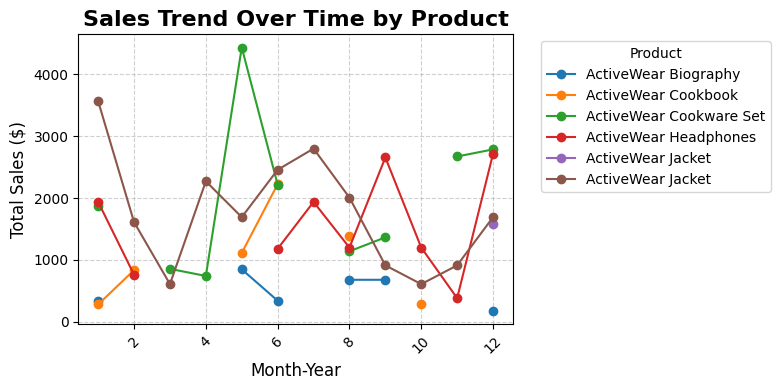

In [21]:

# Extract Year and Month from 'TransactionDate'
df['Year'] = df['TransactionDate'].dt.year
df['Month'] = df['TransactionDate'].dt.month

# Group by Product, Year, Month, and sum the TotalValue
sales_trend = df.groupby(['ProductName', 'Year', 'Month'])['TotalValue'].sum().unstack(level=[0, 1])

# Plotting the line graph for a few selected products
plt.figure(figsize=(8, 4))
for product in sales_trend.columns.levels[0][:5]:  # Plot top 5 products for clarity
    plt.plot(sales_trend.index, sales_trend[product], marker='o', label=product)

plt.title('Sales Trend Over Time by Product', fontsize=16, fontweight='bold')
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Piechart of Top Categories by Total Sales**

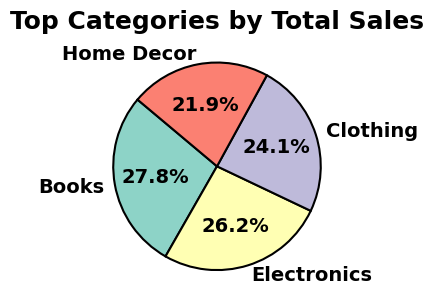

In [22]:
# Group by Category and sum the TotalValue
category_sales = df.groupby('Category')['TotalValue'].sum().sort_values(ascending=False)

# Select top N categories (for example, top 5)
top_categories = category_sales.head(5)

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(top_categories, labels=top_categories.index, autopct='%1.1f%%',
        colors=sns.color_palette('Set3', len(top_categories)), startangle=140,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
        textprops={'fontsize': 14, 'fontweight': 'bold', 'color': 'black'})

# Adding title and styling
plt.title('Top Categories by Total Sales', fontsize=18, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


**Top 3 Products per Category**

<ipython-input-23-d746ba2304ad>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




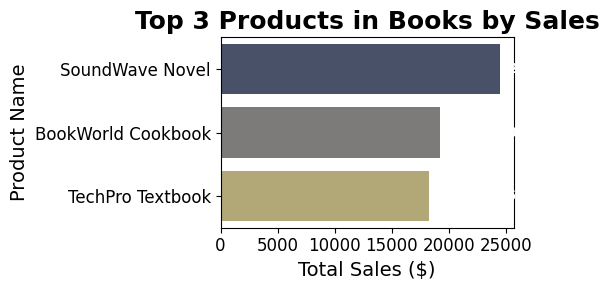

<ipython-input-23-d746ba2304ad>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




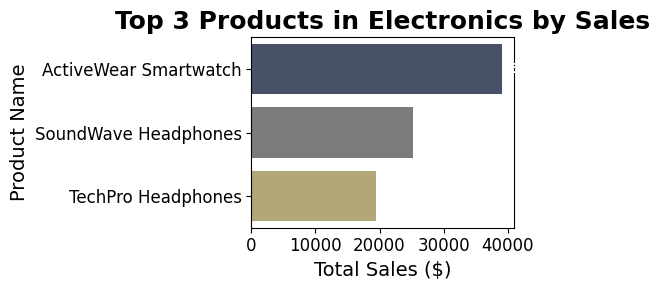

<ipython-input-23-d746ba2304ad>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




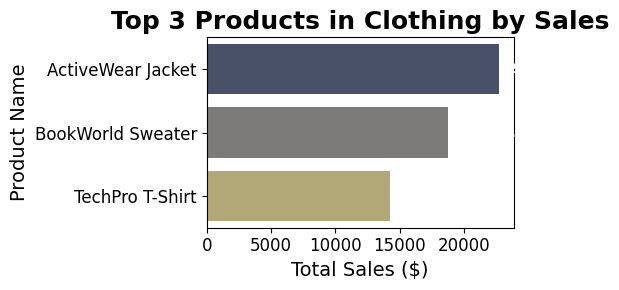

<ipython-input-23-d746ba2304ad>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




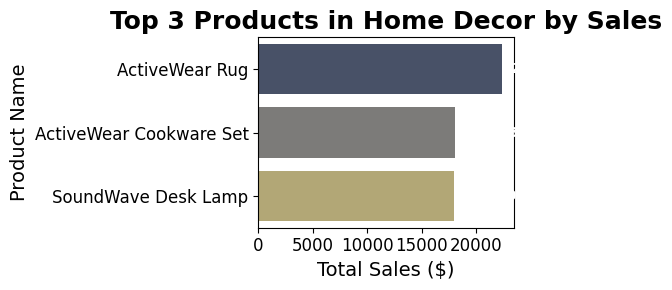

In [23]:
# Loop through each top category and plot top 3 products
for category in top_categories.index:
    # Filter data for the category
    category_data = df[df['Category'] == category]

    # Group by Product and sum the TotalValue
    product_sales = category_data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(3)

    # Plotting the bar chart for top 3 products in the category
    plt.figure(figsize=(6, 3))
    sns.barplot(x=product_sales.values, y=product_sales.index, palette='cividis')

    # Add annotations to bars
    for index, value in enumerate(product_sales.values):
        plt.text(value + 10, index, f'${value:,.2f}', va='center', fontweight='bold', color='white')

    plt.title(f'Top 3 Products in {category} by Sales', fontsize=18, fontweight='bold')
    plt.xlabel('Total Sales ($)', fontsize=14)
    plt.ylabel('Product Name', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


# Insight 5: Customer lifetime Value (CLV)

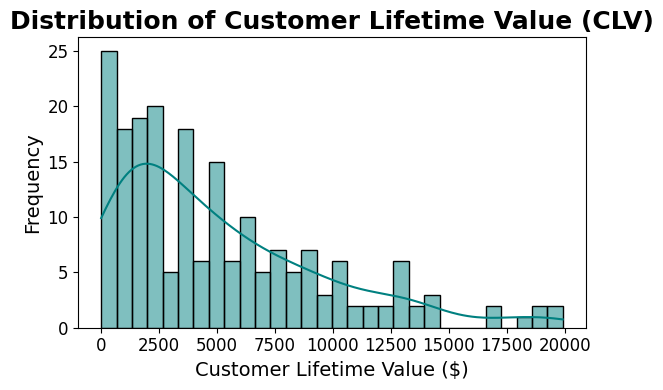

In [19]:
# Customer Lifetime Value (CLV) – Visualizing Average CLV per Customer

# Calculate Average Purchase Value, Purchase Frequency, and Customer Lifespan

# Average Purchase Value: Total Sales / Number of Transactions
average_purchase_value = df.groupby('CustomerID')['TotalValue'].sum() / df.groupby('CustomerID')['TransactionID'].count()

# Purchase Frequency: Total Transactions / Number of Unique Customers
purchase_frequency = df.groupby('CustomerID')['TransactionID'].count()

# Customer Lifespan: Time from SignupDate to Last TransactionDate
df['CustomerLifespan'] = (df['TransactionDate'].max() - df['SignupDate']).dt.days / 365  # Convert to years
customer_lifespan = df.groupby('CustomerID')['CustomerLifespan'].max()

# Calculate CLV
clv = average_purchase_value * purchase_frequency * customer_lifespan

# Plotting CLV
plt.figure(figsize=(6, 4))
sns.histplot(clv, kde=True, color='teal', bins=30)
plt.title('Distribution of Customer Lifetime Value (CLV)', fontsize=18, fontweight='bold')
plt.xlabel('Customer Lifetime Value ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
